In [1]:
import os
import torch
import pytorch_lightning as pl
import matplotlib.pyplot as plt

from utils import tools
from modules.vae_base_module import VAEBaseModule
from models.vae_simple import SimpleVAE
from datasets.novelty_mnist import NoveltyMNISTDataModule

%matplotlib inline
plt.style.use('seaborn')


In [2]:
default_path = os.path.join(os.getcwd(), '../configs/vae/vae_simple_emnist.yaml')
config = tools.config_from_command_line(default_path)

Experimental parameters
------
{'data-parameters': {'batch_size': 128,
                     'download': True,
                     'root_data_path': '/home/fenrir/Documents/Datasets/NoveltyMNIST',
                     'train_fraction': 0.9},
 'experiment-parameters': {'datamodule': 'NoveltyMNISTDataModule',
                           'log_dir': 'logs',
                           'name': 'VAESimple'},
 'module-parameters': {'latent_dims': 10, 'learning_rate': 0.001}}


In [3]:
datamodule = NoveltyMNISTDataModule(**config['data-parameters'])
datamodule.setup('test')

model = SimpleVAE(datamodule.shape, **config['module-parameters'])

module = VAEBaseModule(model, **config['module-parameters'])

checkpoint = torch.load('../logs/VAESimple/version_1/checkpoints/epoch=34-step=11794.ckpt')
module.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [4]:
test_novelty_scores = []
test_novelty_labels = []

module.model.eval()
with torch.no_grad():
    for batch_nb, batch_tuple in enumerate(datamodule.test_dataloader()):
        result = module.test_step(batch_tuple, batch_nb);
#         print(result['scores'].shape)
#         print(result['labels'].shape)
        test_novelty_scores.extend(result['scores'].numpy())
        test_novelty_labels.extend(result['labels'].numpy())
        
    # enumerate dataloader
    # write test step for module
    # return novelty scores


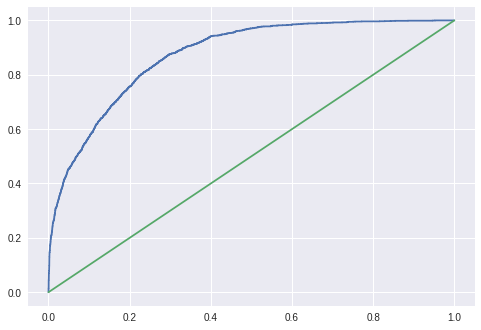

Model ROC AUC:  0.8733834009316103
Random ROC AUC:  0.5


In [6]:
from sklearn import metrics

fpr, tpr, thresholds = metrics.roc_curve(test_novelty_labels, test_novelty_scores)
roc_auc_score = metrics.roc_auc_score(test_novelty_labels, test_novelty_scores)
roc_auc_score_rand = metrics.roc_auc_score([*[0.]*400, *[1.]*400], [0.5]*800)

plt.plot(fpr, tpr)
plt.plot([0., 1.], [0., 1.])
plt.show()
print('Model ROC AUC: ', roc_auc_score)
print('Random ROC AUC: ', roc_auc_score_rand)